# Cart Pole with Actor Critic

In [37]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Conv2D, Flatten

In [38]:
def create_model(state_space, action_space, actor_lr, critic_lr):
    x = Input(state_space, name='input_state')
    #x = Flatten(input_shape=(state_space,))(x)
    #x = Dense(state_space, activation="elu", kernel_initializer='he_uniform')(x)
    #x = Dense(state_space, activation="relu")(x)
    
    # actor learns policy
    action = Dense(action_space, activation="softmax", kernel_initializer='he_uniform', name='policy')(x)
    actor = Model(inputs=x, outputs=action, name='actor')
    actor.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=actor_lr))

    # critic learns value-function
    value = Dense(1, kernel_initializer='he_uniform', name='value')(x)
    critic = Model(inputs=x, outputs=value, name='critic')
    critic.compile(loss='mse', optimizer=RMSprop(lr=critic_lr))
    actor.summary()
    critic.summary()
    return actor, critic

def next_action(actor, state, action_space):
    policy = actor.predict(state, batch_size=1).flatten()
    return np.random.choice(action_space, 1, p=policy)[0]

#### Hyper-parameters

In [39]:
env = gym.make('CartPole-v1')

action_space = env.action_space.n
state_space = env.observation_space.shape[0]
n_episodes = 200
actor_lr = 0.001
critic_lr = 0.001
gamma = 0.99

render = False

#### A2C Algorithm

In [40]:
actor, critic = create_model(state_space, action_space, actor_lr, critic_lr)

Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
policy (Dense)               (None, 2)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
value (Dense)                (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [41]:
scores = []
losses = []
episodes = []

for e in range(n_episodes):
    done = False
    score = 0
    ep_losses = []
    state = env.reset()
    # https://stackoverflow.com/questions/60911279/is-it-possible-to-get-an-image-of-environment-in-openai-gym
    #state = env.render(mode="rgb_array")
    state = np.reshape(state, [1, state_space])

    while not done:
        if render:
            env.render()
        action = next_action(actor, state, action_space)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_space])
        # the max score for the cartpole is 499
        reward = reward if not done or score == 499 else -100

        # value iteration and policy gradient
        value_target = np.zeros((1, 1))
        policy_target = np.zeros((1, action_space))

        value = critic.predict(state)[0]  # get value for this state
        next_value = critic.predict(next_state)[0]  # get value for the next state

        if done:
            value_target[0][0] = reward
            policy_target[0][action] = reward - value
        else:
            value_target[0][0] = reward + gamma * next_value
            policy_target[0][action] = reward + gamma * next_value - value  # advantage

        critic.fit(state, value_target, epochs=1, verbose=0)
        history = actor.fit(state, policy_target, epochs=1, verbose=0)
        loss = history.history['loss'][0]
        ep_losses.append(loss)

        # update scores and state
        score += reward
        state = next_state
        if done:
            score = score if score == 500.0 else (score + 100)
            scores.append(score)
            episodes.append(e)
            losses.append(np.mean(ep_losses))
    
    if e % 50 == 0:
        actor.save_weights("./save_model/cartpole_actor.h5")
        critic.save_weights("./save_model/cartpole_critic.h5")
        print(f"episode: {e+1}/{n_episodes}, score: {score}, loss: {losses[-1]}")

episode: 1/200, score: 14.0, loss: -4.329420600334803
episode: 51/200, score: 18.0, loss: -3.5988173876938068
episode: 101/200, score: 8.0, loss: -8.121656974156698
episode: 151/200, score: 10.0, loss: -1.162422919815237


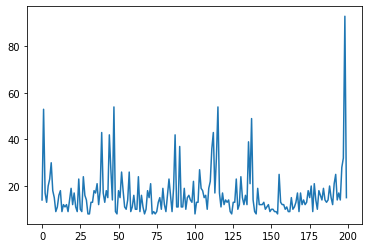

In [42]:
plt.plot(scores)

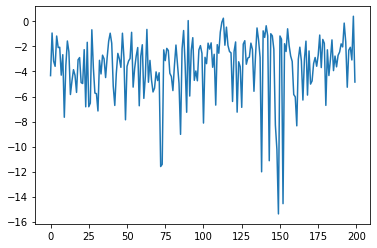

In [43]:
plt.plot(losses)